# The Bench Mark Model (Mobile Net V2)

This is the model which will act as a benchmark for all other models. The model is designed to be what other models aspire to achieve interms of accuracy on my dataset.

In [1]:
import tensorflow as tf
import numpy as np
import os
import numpy as np 
import matplotlib.pyplot as plt
import glob
import shutil
import tensorflow_hub as hub

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix,roc_curve,auc, roc_auc_score,precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay,ConfusionMatrixDisplay

In [3]:
_URL = 'https://fire-net-datasets.s3.amazonaws.com/Training+Dataset.zip'

zip_file = tf.keras.utils.get_file(origin=_URL,extract=True)  
#This will get the file and extract it to a directory and extract to /Training Dataset

505036800/505020699 [==============================] - 9s 0us/step


In [4]:
print(os.path.dirname(zip_file))
#This function returns the directory of the extracted folder without the extracted folder inclusive

/root/.keras/datasets


In [5]:
base_dir = os.path.join(os.path.dirname(zip_file), 'Training Dataset')
#A good way to add the directory of the extracted folder and also the extracted folder itself.
print(base_dir)

/root/.keras/datasets/Training Dataset


In [6]:
classes = ['Fire', 'NoFire']

In [7]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.7)], images[round(len(images)*0.7):]

  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

Fire: 1124 Images
NoFire: 1301 Images


In [8]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [9]:
batch_size = 50
IMG_SHAPE = 128

In [10]:
image_gen_train = ImageDataGenerator(rescale = 1./255,
                    zoom_range = 0.5,
                    rotation_range=45,
                    horizontal_flip=True,
                    width_shift_range=0.15,
                    height_shift_range=0.15,
                    shear_range=0.2)
train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                            directory=train_dir,
                                            shuffle=True,
                                            target_size=(IMG_SHAPE,IMG_SHAPE),
                                            class_mode='binary')
print(train_data_gen.samples)
print(train_data_gen.n)
#Find our size of datasets. each

Found 1698 images belonging to 2 classes.
1698
1698


In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

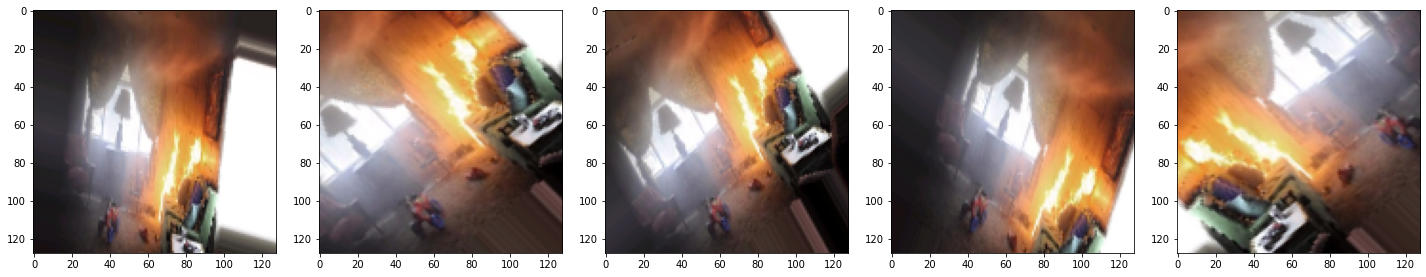

In [12]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [23]:
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                            directory=val_dir,
                            shuffle = False,
                            target_size=(IMG_SHAPE,IMG_SHAPE),
                            class_mode='binary')
#put shuffle=False when you do test_datagen.flow_from_directory() so the samples don't get shuffled and have the same order as validation_generator.classes

Found 727 images belonging to 2 classes.


In [14]:
URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_128/feature_vector/5'
feature_extractor = hub.KerasLayer(URL, input_shape=(IMG_SHAPE,IMG_SHAPE,3))

In [15]:
feature_extractor.trainable=False

In [16]:
model = tf.keras.models.Sequential([
    feature_extractor,
    tf.keras.layers.Dense(2,activation=tf.nn.softmax)
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [18]:
EPOCHS = 50
model.compile(optimizer="adam",
                loss=tf.keras.losses.sparse_categorical_crossentropy,
                metrics=['accuracy'])

reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='auto')
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, mode='auto')

#Can use one reduce Learning Rate or Early Stopping.

#Since we have a reduce learning rate, curve will become smooth, no need to restore best weights since best
#weights may be the ones got at the early stop when the val_loss hasn't changed by 1e-4 when curve has smoothened.

history = model.fit(train_data_gen,epochs= EPOCHS,
                validation_data = val_data_gen,callbacks = [reducelr,earlystop])

Epoch 1/50
34/34 [==============================] - 55s 1s/step - loss: 0.4765 - accuracy: 0.7780 - val_loss: 0.2425 - val_accuracy: 0.9023 - lr: 0.0010
Epoch 2/50
34/34 [==============================] - 40s 1s/step - loss: 0.2541 - accuracy: 0.8910 - val_loss: 0.1930 - val_accuracy: 0.9188 - lr: 0.0010
Epoch 3/50
34/34 [==============================] - 41s 1s/step - loss: 0.2050 - accuracy: 0.9164 - val_loss: 0.1863 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 4/50
34/34 [==============================] - 41s 1s/step - loss: 0.1795 - accuracy: 0.9240 - val_loss: 0.1981 - val_accuracy: 0.9257 - lr: 0.0010
Epoch 5/50
34/34 [==============================] - 40s 1s/step - loss: 0.1772 - accuracy: 0.9264 - val_loss: 0.1756 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 6/50
34/34 [==============================] - 40s 1s/step - loss: 0.1729 - accuracy: 0.9317 - val_loss: 0.1541 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 7/50
34/34 [==============================] - 40s 1s/step - loss: 0.1595 - a

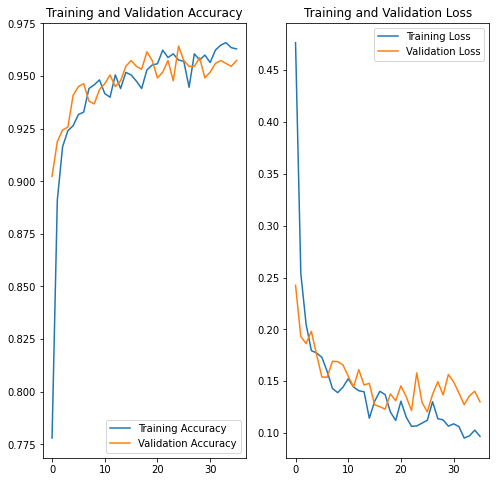

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(history.history['loss']))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range,acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [28]:
#Confusion Matrix and Classification Report

#Something is Wrong
val_data_gen.reset()
Y_pred = model.predict(val_data_gen, int(np.ceil(val_data_gen.n / float(batch_size))))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(val_data_gen.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(val_data_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[314  23]
 [  8 382]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.98      0.93      0.95       337
     No Fire       0.94      0.98      0.96       390

    accuracy                           0.96       727
   macro avg       0.96      0.96      0.96       727
weighted avg       0.96      0.96      0.96       727



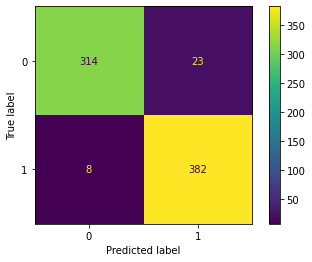

In [25]:
cm = confusion_matrix(val_data_gen.classes, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

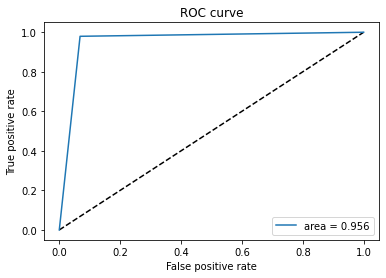

In [26]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(val_data_gen.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

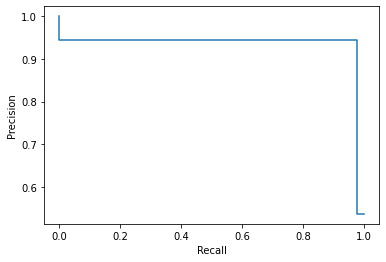

In [27]:
prec, recall, _ = precision_recall_curve(val_data_gen.classes, y_pred)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()